In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [2]:
resolution = 100
nfreq = 100

fcen = 1.75
df = 3.3

In [3]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000005
Iteration   1, error: 0.000063
Iteration   2, error: 0.000109
Iteration   3, error: 0.000036
Iteration   4, error: 0.000005
Iteration   5, error: 0.000100
Iteration   6, error: 0.000010
Iteration   7, error: 0.000006
Iteration   8, error: 0.000019
Iteration   9, error: 0.000013
Iteration  10, error: 0.000011
Iteration  11, error: 0.000009
Iteration  12, error: 0.000290
Iteration  13, error: 0.000016
Iteration  14, error: 0.000013
Iteration  15, error: 0.000007
Iteration  16, error: 0.000010
Iteration  17, error: 0.000009
Iteration  18, error: 0.000009
Iteration  19, error: 0.000007
Iteration  20, error: 0.000072
Iteration  21, error: 0.000008
Iteration  22, error: 0.000036
Iteration  23, error: 0.000029
Iteration  24, error: 0.000008
Iteration  25, error: 0.000062
Iteration  26, error: 0.000009
Iteration  27, error: 0.000080
Iteration  28, error: 0.000010
Iteration  29, error: 0.000029
Optimal error: 0.000005
Iteration   0, error: 64.226780
Iteration   1,

In [4]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

pml_layer = 0.3

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
    
]

geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, -0.85, 0),
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, -0.67, 0),
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, -0.615, 0),
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, -0.515, 0),
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, -0.405, 0),
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, 0.315, 0),
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

cell_size = mp.Vector3(30, 2, 0)

source_center = mp.Vector3(0,-0.67,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

# === 시뮬레이션 설정 === #
sim_oled = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

# --- Flux 모니터 4면 등록 (tight box 기준) ---
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

# 박스 4면
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

# 박스 4면
x1_oled = sim_oled.add_flux(
    fcen, df, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        # weight=-1
    ),
)

x2_oled = sim_oled.add_flux(
    fcen, df, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1_oled = sim_oled.add_flux(
    fcen, df, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        # weight=-1
    ),
)

y2_oled = sim_oled.add_flux(
    fcen, df, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/mp/lib/python3.8/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


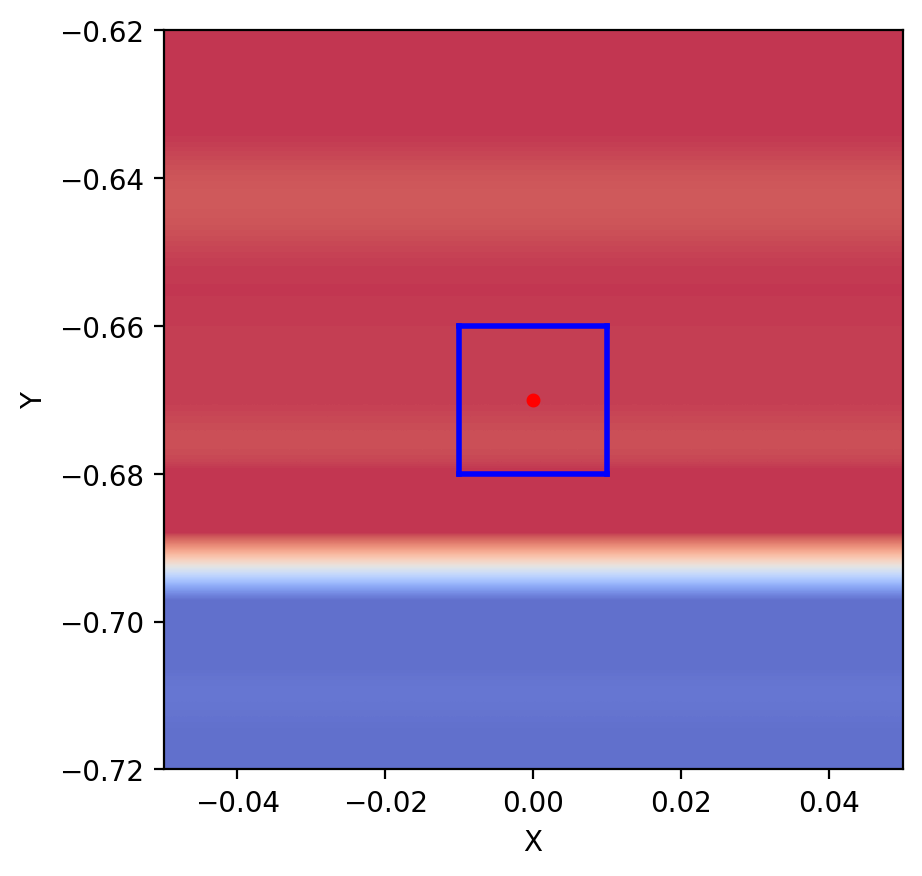

In [5]:
# center와 size를 사용해 Volume 객체 생성
vol = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 2, 0))
fig = plt.figure(dpi=200)
ax = plt.gca()

# 그 volume을 사용해서 2D 시각화
sim_oled.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,-0.67,0), size=mp.Vector3(0.1, 0.1, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)
plt.show()

In [6]:
sim_oled.init_sim()

sim_oled.run(until=50)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000456095 s
Working in 2D dimensions.
Computational cell is 30 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

In [7]:
x1_flux_oled = mp.get_fluxes(x1_oled)
x2_flux_oled = mp.get_fluxes(x2_oled)
y1_flux_oled = mp.get_fluxes(y1_oled)
y2_flux_oled = mp.get_fluxes(y2_oled)

# 여기서부터는 air

In [8]:
air_source_center = mp.Vector3(0,0,0)
air_sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=air_source_center,
    size=mp.Vector3(0,0)
)]

sim_air = mp.Simulation(
    cell_size=mp.Vector3(1,1,0),
    default_material=mp.Medium(index=1),
    boundary_layers=boundary_layers,
    sources=air_sources,
    resolution=resolution
)

In [9]:
# 박스 4면
offset = 0.01
flux_size = 0.02


# 박스 4면
x1_air = sim_air.add_flux(
    fcen, df, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=air_source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        # weight=-1
    ),
)

x2_air = sim_air.add_flux(
    fcen, df, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=air_source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1_air = sim_air.add_flux(
    fcen, df, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=air_source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        # weight=-1
    ),
)

y2_air = sim_air.add_flux(
    fcen, df, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=air_source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

<Axes: xlabel='X', ylabel='Y'>

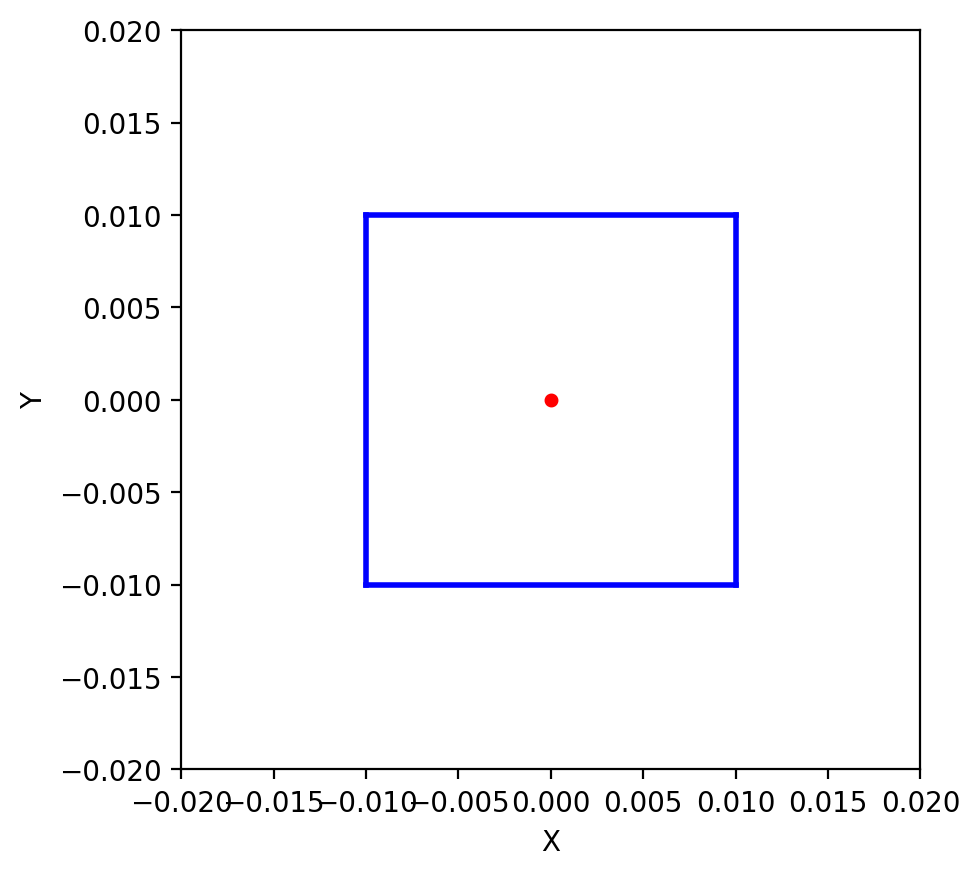

In [10]:
fig = plt.figure(dpi=200)
ax = plt.gca()

sim_air.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(0.04, 0.04, 0)),
    # eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

In [11]:
sim_air.init_sim()
# sim_air.run(until = 50)
sim_air.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, air_source_center+mp.Vector3(1,0,0), 1e-6))


-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.00531507 s
-----------
run 0 finished at t = 50.005 (10001 timesteps)


# 여기서부터는 normalize

In [30]:
freq_data = mp.get_flux_freqs(x1_air)

wavelengths = 1 / np.array(freq_data)

oled_x1_data = mp.get_fluxes(x1_oled)
oled_x2_data = mp.get_fluxes(x2_oled)
oled_y1_data = mp.get_fluxes(y1_oled)
oled_y2_data = mp.get_fluxes(y2_oled)

air_x1_data = mp.get_fluxes(x1_air)
air_x2_data = mp.get_fluxes(x2_air)
air_y1_data = mp.get_fluxes(y1_air)
air_y2_data = mp.get_fluxes(y2_air)

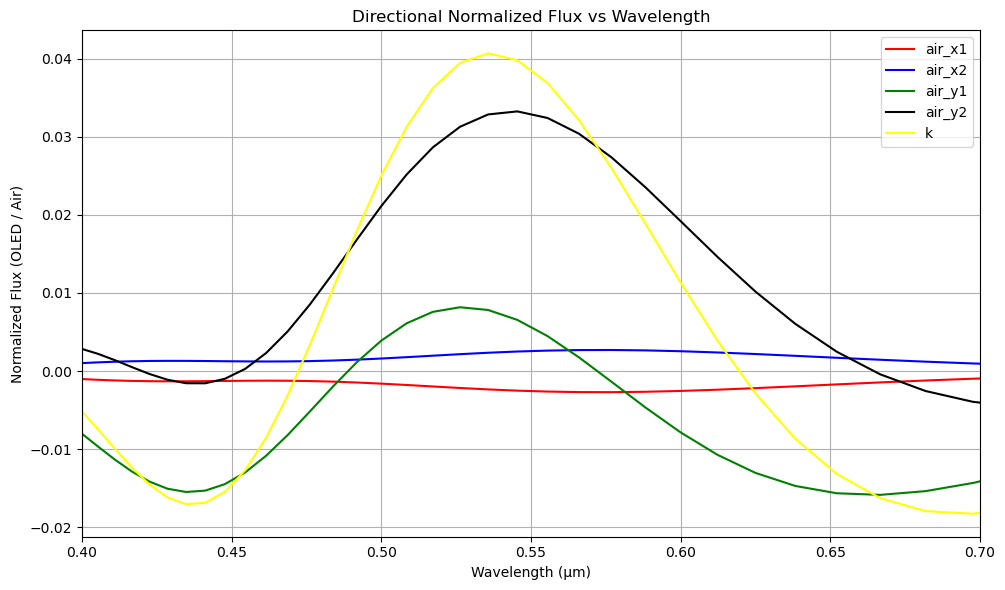

In [ ]:
# 정규화된 directional flux 계산
air_x1 = np.array(air_x1_data)
air_x2 = np.array(air_x2_data)

air_y1 = np.array(air_y1_data)
air_y2 = np.array(air_y2_data)

k = air_x1+air_x2+air_y1+air_y2
# k = np.array(oled_x1_data)+np.array(oled_x2_data)+np.array(oled_y1_data)+np.array(oled_y2_data)
# k2 = np.array(air_x1_data)+np.array(air_x2_data)+np.array(air_y1_data)+np.array(air_y2_data)
# k3 = k / k2

plt.figure(figsize=(10, 6))
plt.plot(wavelengths,air_x1, label='air_x1', color='red')
plt.plot(wavelengths,air_x2, label='air_x2', color='blue')
plt.plot(wavelengths,air_y1, label='air_y1', color='green')
plt.plot(wavelengths,air_y2, label='air_y2', color='black')

# plt.plot(wavelengths,k2, label='k2 (left)', color='red')
# plt.plot(wavelengths,k3, label='k3 (left)', color='blue')

plt.xlabel("Wavelength (μm)")
plt.ylabel("Normalized Flux (OLED / Air)")
plt.title("Directional Normalized Flux vs Wavelength")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim([0.4, 0.7])
# plt.ylim([-4,4])
plt.show()

(0.4, 0.7)

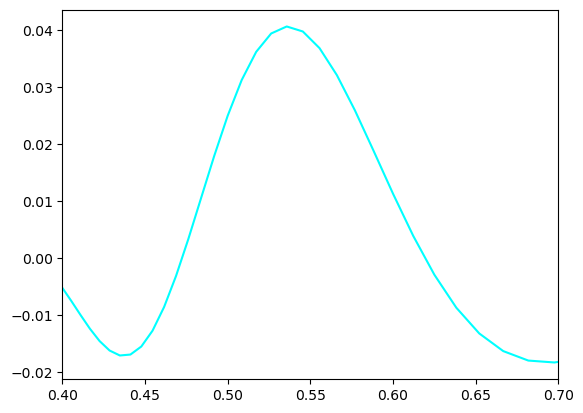

In [22]:
plt.plot(wavelengths,k, label='k', color='cyan')
plt.xlim([0.4, 0.7])

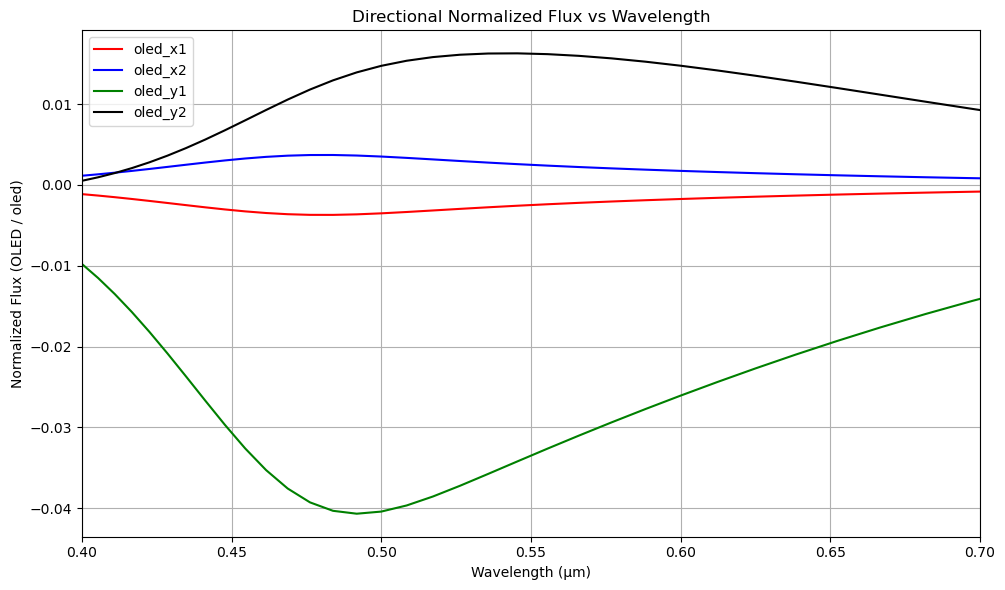

In [39]:
oled_x1 = np.array(oled_x1_data)
oled_x2 = np.array(oled_x2_data)

oled_y1 = np.array(oled_y1_data)
oled_y2 = -np.array(oled_y2_data)

p = oled_x1+oled_x2+oled_y1+oled_y2

plt.figure(figsize=(10, 6))
plt.plot(wavelengths,oled_x1, label='oled_x1', color='red')
plt.plot(wavelengths,oled_x2, label='oled_x2', color='blue')
plt.plot(wavelengths,oled_y1, label='oled_y1', color='green')
plt.plot(wavelengths,oled_y2, label='oled_y2', color='black')

# plt.plot(wavelengths,k2, label='k2 (left)', color='red')
# plt.plot(wavelengths,k3, label='k3 (left)', color='blue')

plt.xlabel("Wavelength (μm)")
plt.ylabel("Normalized Flux (OLED / oled)")
plt.title("Directional Normalized Flux vs Wavelength")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim([0.4, 0.7])
# plt.ylim([-4,4])
plt.show()

(0.4, 0.7)

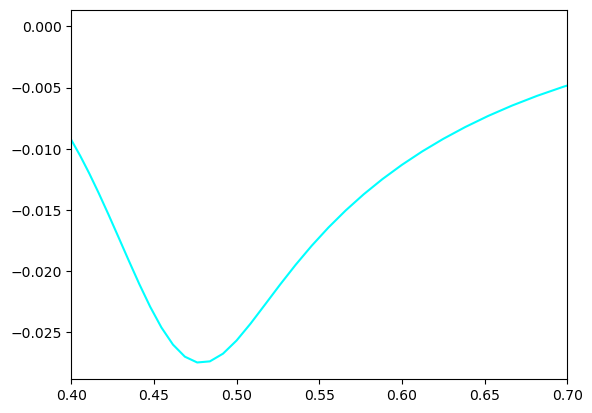

In [40]:
plt.plot(wavelengths,p, label='p', color='cyan')
plt.xlim([0.4, 0.7])

(-4.0, 14.0)

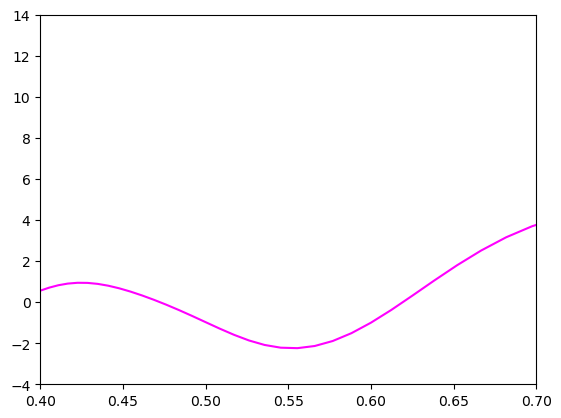

In [42]:
norm = k / p
plt.plot(wavelengths,norm, label='p', color='magenta')
plt.xlim([0.4, 0.7])
plt.ylim([-4, 14])